In [7]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchtext
import torchtext.transforms as T
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.schemas import NlpContext
from torchlake.sequence_data.models import LstmClassifier
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm

In [8]:
torch.__version__

'2.1.0+cu118'

In [9]:
torchtext.__version__

'0.16.0+cpu'

# setting


In [11]:
batch_size = 128
context = NlpContext()

In [12]:
tokenizer = get_tokenizer("basic_english")

In [13]:
artifact_path = Path("../../artifacts/lstm")
dataset_path = Path("../../data/IMDB")

# dataset


In [14]:
def datapipe_factory(datapipe, transform=None):
    datapipe = (
        datapipe
            .map(lambda item: (item[0], item[1].strip()))
            .map(lambda item: (item[0], item[1].lower()))
            .filter(lambda item: len(item[1]) > context.min_seq_len)
            .map(lambda item: (item[0], tokenizer(item[1])))
        # .map(lambda text: drop_keywords(text, stopwords.words('english')))
        # .filter(lambda tokens: drop_short_text(tokens, context_size))
    )

    if transform:
        datapipe = datapipe.map(lambda item: (item[0], transform(item[1])))

    return datapipe

In [63]:
train_datapipe, test_datapipe = torchtext.datasets.IMDB(dataset_path.as_posix())

In [16]:
vocab = build_vocab_from_iterator(
    map(lambda x: x[1], datapipe_factory(test_datapipe)),
    specials=["<unk>", "<bos>", "<eos>", "<pad>"],
    min_freq=context.min_frequency,
)

vocab.set_default_index(context.unk_idex)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [17]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [18]:
train_datapipe = datapipe_factory(
    train_datapipe,
    text_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    text_transform,
)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [19]:
def collate_fn(batch: list):
    text_placeholder, label_placeholder = [], []
    for label, text in batch:
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.Tensor(label_placeholder)

In [20]:
train_dataloader = DataLoader(
    train_datapipe,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=batch_size,
    collate_fn=collate_fn,
)

In [21]:
for text, label in train_dataloader:
    print(text.shape, label.shape)
    break

torch.Size([128, 256]) torch.Size([128])


# model


In [22]:
vocab_size = len(vocab)
vocab_size

29575

In [41]:
device = torch.device(context.device)

In [42]:
embed_dim = 128
hidden_dim = 128
model = LstmClassifier(
    vocab_size,
    embed_dim,
    hidden_dim,
    padding_idx=context.padding_idx,
).to(device)

In [43]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [44]:
epoches = 20

In [45]:
model.train()
training_loss = []
for epoch in range(epoches):
    running_loss = 0.0
    batch_idx = 0
    for text, label in tqdm(test_dataloader):
        optimizer.zero_grad()

        text = text.to(device)
        label = label.to(device)
        output = model(text).squeeze(1)

        loss = criterion(output, label - 1)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        batch_idx += 1

    mean_running_loss = running_loss / batch_idx
    training_loss.append(mean_running_loss)
    print(f"epoch {epoch+1} : {mean_running_loss}")

0it [00:00, ?it/s]

196it [00:14, 13.81it/s]


epoch 1 : 0.5094658400921617


196it [00:17, 11.31it/s]


epoch 2 : 0.9083282400150688


196it [00:14, 13.29it/s]


epoch 3 : 0.7719155477017773


196it [00:16, 11.96it/s]


epoch 4 : 0.7451009767092004


196it [00:15, 12.65it/s]


epoch 5 : 0.7398646355283504


196it [00:14, 13.23it/s]


epoch 6 : 0.7393472684281213


196it [00:14, 13.36it/s]


epoch 7 : 0.7254153573695494


196it [00:14, 13.74it/s]


epoch 8 : 0.5061128403829905


196it [00:15, 12.82it/s]


epoch 9 : 0.6950591549619424


196it [00:15, 12.98it/s]


epoch 10 : 0.680843211482374


196it [00:14, 13.08it/s]


epoch 11 : 0.7763930247830493


196it [00:14, 13.43it/s]


epoch 12 : 0.5891653177879599


196it [00:15, 12.86it/s]


epoch 13 : 0.6448498954046138


196it [00:15, 12.78it/s]


epoch 14 : 0.7459239762808595


196it [00:15, 12.88it/s]


epoch 15 : 0.7553410968002008


196it [00:15, 12.95it/s]


epoch 16 : 0.6967497174533046


196it [00:14, 13.74it/s]


epoch 17 : 0.5991585518100432


196it [00:14, 13.50it/s]


epoch 18 : 0.6975125844913478


196it [00:14, 13.33it/s]


epoch 19 : 0.7172137197411182


196it [00:14, 13.26it/s]

epoch 20 : 0.7562862676473296


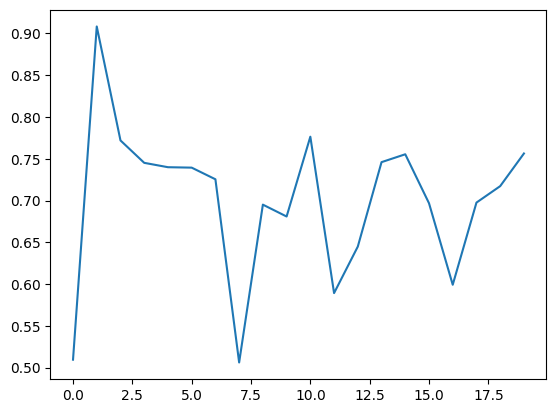

In [46]:
plt.plot(training_loss)

# inference


In [55]:
model.eval()
with torch.no_grad():
    running_hit = 0.0
    data_size = 0

    for text, label in tqdm(test_dataloader):
        text = text.to(device)
        label = label.to(device)

        output = model(text).squeeze(1)
        pred = output.sigmoid() > 0.5
        running_hit += (pred == (label - 1)).sum().item()
        data_size += text.size(0)

    print(running_hit / data_size)

196it [00:15, 12.60it/s]

0.5


In [56]:
model_path = artifact_path.joinpath("lstm.pth")

In [57]:
torch.save(model.state_dict(), model_path)

In [58]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [59]:
model(
    text_transform(tokenizer("It was such a good movie I have ever seen"))
    .unsqueeze(0)
    .to(device)
).sigmoid()

tensor([[0.8360]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [60]:
model(
    text_transform(tokenizer("So bad a movie can be, waste my money"))
    .unsqueeze(0)
    .to(device)
).sigmoid()

tensor([[0.8360]], device='cuda:0', grad_fn=<SigmoidBackward0>)